In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display
import tqdm
import optuna

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

from seaborn_analyzer import regplot
from lightgbm import LGBMRegressor

from utils.mmd import mmd_rbf_unbiased
from utils.slicedWassersteinDistance import sliced_wasserstein_distance

import xgboost as xgb
from xgboost import XGBRegressor


In [2]:
raw = pd.read_excel('../data/raw/kadai.xlsx')
raw.shape

(2276, 86)

In [3]:
raw.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [4]:
def df_set_datetime(df, col_name):
    for col in col_name:
        df[col] = pd.to_datetime(df[col])
    return df

raw = df_set_datetime(raw, ["process_end_time", "final_mes_time"])
raw.shape

(2276, 86)

In [5]:
raw.head(5)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [6]:
# process_end_time と final_mes_time で groupby し、クラスタID（batch_id）を付与する
raw["batch_id"] = raw.groupby(["process_end_time"]).ngroup()


In [7]:
raw.head(1779)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,batch_id
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774,2016-11-28 07:26:00,2017-01-18 14:47:00,131.6603,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,75
1775,2016-11-28 07:26:00,2017-01-18 16:38:00,123.1508,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,75
1776,2016-11-28 07:26:00,2017-01-18 17:13:00,130.1202,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,75
1777,2016-11-28 07:26:00,2017-01-18 17:53:00,115.6764,23.62,9.35,705.91,0.64,0.14,0.08,127.48,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,75


In [8]:
corr_list = []
for target_batch in range(1, 84):
    A = raw[raw["batch_id"] < target_batch].reset_index(drop=True)
    for i in A.corr()["OV"].abs().sort_values(ascending=False)[1:6].index.tolist():
        corr_list.append(i)

In [9]:
top5_corr = Counter(corr_list).most_common(5)
top5_corr

[('X33', 64), ('X22', 47), ('X32', 47), ('X30', 41), ('X31', 36)]

In [10]:
batch_cols = [f"X{i}" for i in [33,22,32,30,31]]

start_index = 75
last_batch = raw["batch_id"].max()

swd_dict = {}
for target_batch in range(start_index, last_batch + 1):
    X = raw[raw["batch_id"] == target_batch][batch_cols].reset_index(drop=True)
    scaler = StandardScaler()
    scaler.fit(X)
    Xz = scaler.transform(X)
    swd_list = []
    for b in range(1, target_batch):
        Y = raw[raw["batch_id"] == b][batch_cols].reset_index(drop=True)
        Yz = scaler.transform(Y)
        swd = sliced_wasserstein_distance(Xz, Yz, n_projections=300, seed=0)
        swd_list.append((b, swd))

    swd_sorted = sorted(swd_list, key=lambda x: x[1])[:40]  # TODO: 最適なロット数を探索
    swd_dict[target_batch] = [bid for bid, _ in swd_sorted]
    print(f"batch:{target_batch}  swd5:{swd_dict[target_batch]}")


batch:75  swd5:[66, 70, 2, 41, 60, 58, 59, 61, 55, 4, 73, 65, 64, 63, 62, 71, 56, 50, 54, 57, 72, 48, 32, 1, 74, 3, 9, 10, 12, 15, 18, 19, 21, 23, 25, 28, 40, 45, 6, 5]
batch:76  swd5:[71, 56, 50, 54, 57, 48, 55, 59, 61, 58, 60, 62, 73, 2, 66, 70, 75, 65, 64, 72, 41, 4, 63, 32, 1, 74, 20, 24, 9, 10, 12, 15, 18, 19, 21, 23, 25, 28, 40, 45]
batch:77  swd5:[72, 56, 55, 59, 61, 58, 60, 48, 62, 64, 65, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 2, 4, 52, 49, 53, 32, 1, 42, 41, 5, 8, 11, 13]
batch:78  swd5:[77, 72, 56, 58, 59, 61, 55, 48, 60, 62, 65, 64, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 2, 4, 52, 49, 53, 32, 1, 42, 69, 41, 5, 8]
batch:79  swd5:[78, 77, 72, 56, 58, 59, 61, 55, 48, 60, 65, 62, 64, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 2, 4, 52, 49, 53, 32, 1, 42, 69, 41, 5]
batch:80  swd5:[77, 78, 79, 72, 56, 59, 61, 55, 58, 60, 48, 62, 64, 65, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 2, 4, 52,

In [11]:
pred_list = []

for target_batch in tqdm.tqdm(range(start_index, last_batch + 1)):
    feature_cols = batch_cols.copy()
    train_batches = swd_dict[target_batch]

    train_df = raw[raw["batch_id"].isin(train_batches)].reset_index(drop=True)
    test_df  = raw[raw["batch_id"] == target_batch].reset_index(drop=True)

    X_train = train_df[feature_cols]
    y_train = train_df["OV"]
    X_test = test_df[feature_cols]
    y_test = test_df["OV"]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE(batch:{target_batch}): {rmse:.3f}")

    for p in y_pred:
        pred_list.append(p)

pred_list = pred_list[-500:]

rsme = np.sqrt(mean_squared_error(raw["OV"][-500:], pred_list))
print(f"RMSE: {rsme:.3f}")

  4%|▍         | 1/25 [00:00<00:04,  5.69it/s]

RMSE(batch:75): 30.084


  8%|▊         | 2/25 [00:00<00:03,  5.98it/s]

RMSE(batch:76): 14.485


 12%|█▏        | 3/25 [00:00<00:04,  5.33it/s]

RMSE(batch:77): 55.275


 16%|█▌        | 4/25 [00:00<00:04,  5.02it/s]

RMSE(batch:78): 33.877


 24%|██▍       | 6/25 [00:01<00:03,  4.90it/s]

RMSE(batch:79): 72.858
RMSE(batch:80): 13.864


 28%|██▊       | 7/25 [00:01<00:03,  4.71it/s]

RMSE(batch:81): 24.354


 36%|███▌      | 9/25 [00:01<00:03,  4.93it/s]

RMSE(batch:82): 21.177
RMSE(batch:83): 35.104


 44%|████▍     | 11/25 [00:02<00:02,  5.04it/s]

RMSE(batch:84): 117.347
RMSE(batch:85): 23.071


 52%|█████▏    | 13/25 [00:02<00:02,  5.07it/s]

RMSE(batch:86): 61.070
RMSE(batch:87): 14.877


 60%|██████    | 15/25 [00:02<00:01,  5.07it/s]

RMSE(batch:88): 9.460
RMSE(batch:89): 26.243


 68%|██████▊   | 17/25 [00:03<00:01,  5.05it/s]

RMSE(batch:90): 122.362
RMSE(batch:91): 7.113


 76%|███████▌  | 19/25 [00:03<00:01,  5.08it/s]

RMSE(batch:92): 57.672
RMSE(batch:93): 42.175


 84%|████████▍ | 21/25 [00:04<00:00,  5.03it/s]

RMSE(batch:94): 73.924
RMSE(batch:95): 72.810


 92%|█████████▏| 23/25 [00:04<00:00,  5.19it/s]

RMSE(batch:96): 17.618
RMSE(batch:97): 5.278


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]

RMSE(batch:98): 6.961
RMSE(batch:99): 10.545
RMSE: 53.032


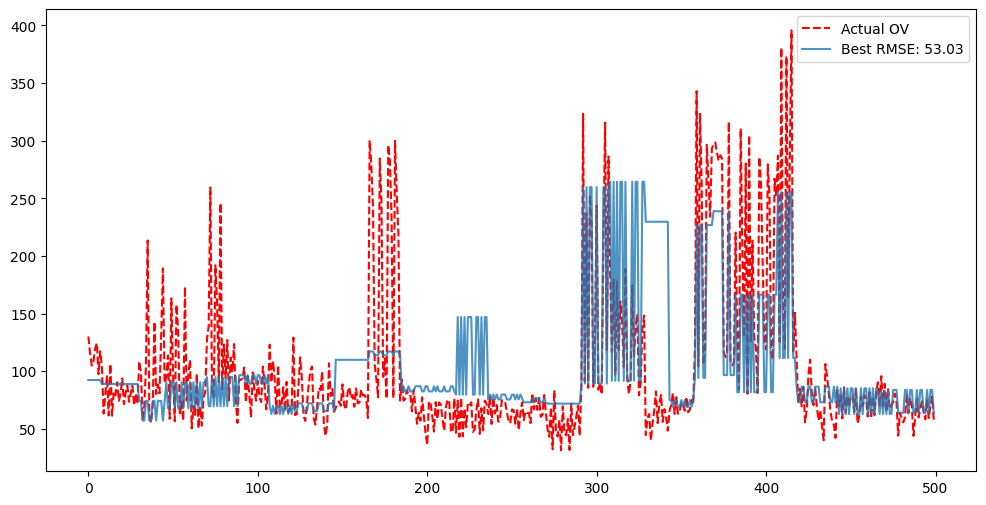

In [12]:
model = "Best"

plt.figure(figsize=(12, 6))
Y_t = raw["OV"][-500:].reset_index(drop=True)
plt.plot(Y_t, label='Actual OV', color='red', linestyle='--')
rmse = np.sqrt(mean_squared_error(Y_t, pred_list))
plt.plot(pred_list, label=f'{model} RMSE: {rmse:.2f}', alpha=0.8)
plt.legend()
plt.show()

In [13]:
batch_90 = raw[raw["batch_id"] == 90].reset_index(drop=True)
batch_90
batch_90.corr()["OV"]
batch_cols = batch_90.corr()["OV"].abs().sort_values(ascending=False)[1:6].index.tolist()
batch_90.corr()["OV"].abs().sort_values(ascending=False)[1:6]

X38    0.944435
X22    0.941844
X33    0.926840
X41    0.878196
X31    0.873092
Name: OV, dtype: float64

In [14]:
batch_84 = raw[raw["batch_id"] == 84].reset_index(drop=True)
batch_84
batch_84.corr()["OV"]
batch_cols = batch_84.corr()["OV"].abs().sort_values(ascending=False)[1:6].index.tolist()
batch_84.corr()["OV"].abs().sort_values(ascending=False)[1:6]


X13    0.967298
X11    0.967298
X32    0.967298
X25    0.967298
X31    0.967298
Name: OV, dtype: float64

## 現状わかっていること

- 全体最適では、`[33,22,32,30,31]`の対OV相関が高く、`RMSE=53.03`
- 局所最適では、`RMSE(batch:84): 117.347`と`RMSE(batch:90): 122.362`を下げる必要がある。
    - `batch:84`: `['X13', 'X11', 'X32', 'X25', 'X31']`
    - `batch:90`: `['X38', 'X22', 'X33', 'X41', 'X31']`

## 今後挑戦すること
- `[X33,X22,X32,X30,X31]`を用いて`[X13, X11, X38]`の変数に近似させる

In [15]:
# test_col =["X13", "X11", "X38"]

train = raw[:500]
test = raw[-500:]

trainX = train[["X33", "X22", "X32", "X30", "X31"]]
testX = test[["X33", "X22", "X32", "X30", "X31"]]

# X13
print("X13--------------------------------")
from sklearn.linear_model import LinearRegression

display(raw["X13"].describe().T)
target = "X13"
model = LinearRegression()
model.fit(trainX, train[target])
rmse = np.sqrt(mean_squared_error(test[target], model.predict(testX)))
print(f"RMSE: {rmse:.3f}")
print(f"RMSE割合:{ rmse/(raw[target].max() - raw[target].min())*100:.3f}%")

import pickle

with open("../data/model/predict_X13.pkl", "wb") as f:
    pickle.dump(model, f)

# X11
print("X11--------------------------------")
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

target = "X11"

model = make_pipeline(
    StandardScaler(),
    SVR(C=10.0, epsilon=0.1, gamma="scale", kernel="rbf")
)

model.fit(trainX, train[target])
pred = model.predict(testX)

rmse = np.sqrt(mean_squared_error(test[target], pred))
print(f"RMSE: {rmse:.3f}")
print(f"RMSE割合: {rmse/(raw[target].max() - raw[target].min())*100:.3f}%")

# X38
print("X38--------------------------------")
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

target = "X38"

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])

pipeline.fit(trainX, train[target])
rmse = np.sqrt(mean_squared_error(test[target], pipeline.predict(testX)))
print(f"RMSE: {rmse:.3f}")
print(f"RMSE割合:{ rmse/(raw[target].max() - raw[target].min())*100:.3f}%")


X13--------------------------------


count    2276.000000
mean        0.563524
std         0.150277
min         0.480000
25%         0.530000
50%         0.560000
75%         0.570000
max         1.670000
Name: X13, dtype: float64

RMSE: 0.025
RMSE割合:2.078%
X11--------------------------------
RMSE: 2.723
RMSE割合: 37.558%
X38--------------------------------
RMSE: 0.064
RMSE割合:25.529%


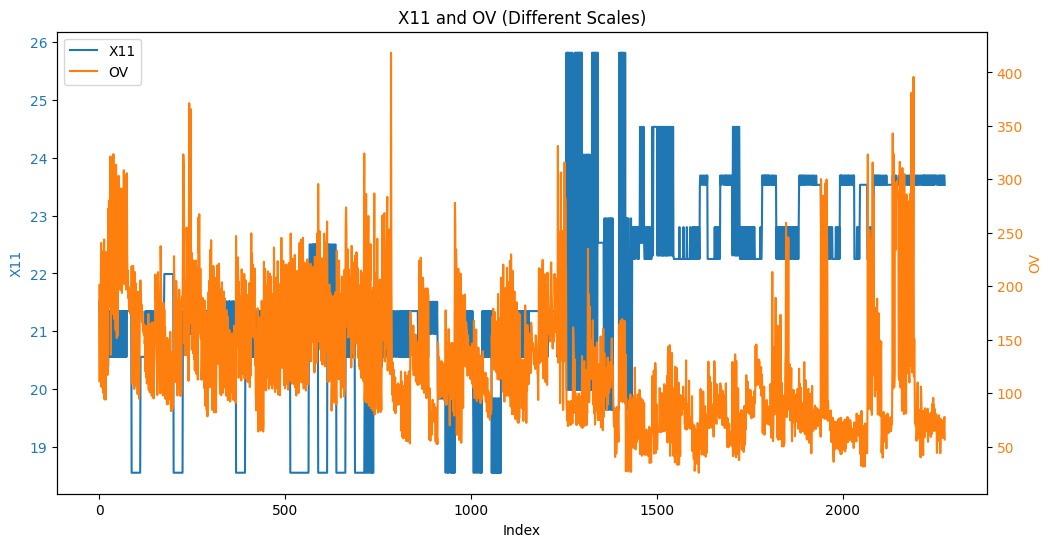

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(raw["X11"], label="X11", color="tab:blue")
ax1.set_ylabel("X11", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(raw["OV"], label="OV", color="tab:orange")
ax2.set_ylabel("OV", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax1.set_xlabel("Index")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("X11 and OV (Different Scales)")
plt.show()

In [17]:
# X11は、高精度で予測できる

def X11_predict(df: pd.DataFrame):
    with open("../data/model/predict_X13.pkl", "rb") as f:
        model = pickle.load(f)
    X11_pred = model.predict(df[["X33", "X22", "X32", "X30", "X31"]])
    return X11_pred

In [18]:
batch_cols = [f"X{i}" for i in [33,22,32,30,31]]

start_index = 75
last_batch = raw["batch_id"].max()


swd_dict = {}
for target_batch in range(start_index, last_batch + 1):
    X = raw[raw["batch_id"] == target_batch][batch_cols].reset_index(drop=True)
    X["X11"] = X11_predict(X)
    scaler = StandardScaler()
    scaler.fit(X)
    Xz = scaler.transform(X)
    swd_list = []
    for b in range(1, target_batch):
        Y = raw[raw["batch_id"] == b][batch_cols].reset_index(drop=True)
        Y["X11"] = X11_predict(Y)
        Yz = scaler.transform(Y)
        swd = sliced_wasserstein_distance(Xz, Yz, n_projections=300, seed=0)
        swd_list.append((b, swd))

    swd_sorted = sorted(swd_list, key=lambda x: x[1])[:40]  # TODO: 最適なロット数を探索
    swd_dict[target_batch] = [bid for bid, _ in swd_sorted]
    print(f"batch:{target_batch}  swd5:{swd_dict[target_batch]}")


batch:75  swd5:[66, 70, 2, 41, 60, 58, 59, 61, 55, 4, 73, 65, 64, 63, 62, 71, 56, 50, 54, 57, 72, 48, 32, 1, 74, 3, 9, 10, 12, 15, 18, 19, 21, 23, 25, 28, 40, 45, 6, 5]
batch:76  swd5:[71, 56, 50, 54, 57, 48, 55, 59, 61, 58, 60, 62, 73, 2, 66, 70, 75, 65, 64, 72, 41, 4, 63, 32, 1, 74, 20, 24, 9, 10, 12, 15, 18, 19, 21, 23, 25, 28, 40, 45]
batch:77  swd5:[72, 56, 60, 58, 59, 61, 55, 48, 62, 64, 65, 73, 50, 54, 57, 71, 76, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 52, 49, 53, 2, 4, 32, 1, 42, 69, 68, 67, 5, 8]
batch:78  swd5:[77, 72, 56, 58, 59, 61, 55, 48, 60, 62, 65, 64, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 52, 49, 53, 2, 4, 32, 1, 42, 69, 68, 5, 8]
batch:79  swd5:[78, 77, 72, 58, 56, 59, 61, 55, 48, 60, 65, 62, 64, 73, 71, 76, 50, 54, 57, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 52, 49, 53, 2, 4, 32, 1, 42, 69, 68, 5]
batch:80  swd5:[77, 78, 79, 72, 56, 60, 58, 59, 61, 55, 48, 62, 64, 65, 73, 50, 54, 57, 71, 76, 63, 66, 70, 75, 35, 27, 30, 20, 24, 74, 52, 49, 5

In [19]:
pred_list = []

for target_batch in tqdm.tqdm(range(start_index, last_batch + 1)):
    feature_cols = [f"X{i}" for i in [33,22,32,30,31, 11]]
    train_batches = swd_dict[target_batch]

    train_df = raw[raw["batch_id"].isin(train_batches)].reset_index(drop=True)
    test_df  = raw[raw["batch_id"] == target_batch].reset_index(drop=True)

    X_train = train_df[feature_cols]
    y_train = train_df["OV"]
    X_test = test_df[feature_cols]
    y_test = test_df["OV"]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=42
        ))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE(batch:{target_batch}): {rmse:.3f}")

    for p in y_pred:
        pred_list.append(p)

pred_list = pred_list[-500:]

rsme = np.sqrt(mean_squared_error(raw["OV"][-500:], pred_list))
print(f"RMSE: {rsme:.3f}")

  4%|▍         | 1/25 [00:00<00:06,  3.99it/s]

RMSE(batch:75): 30.326


  8%|▊         | 2/25 [00:00<00:05,  4.13it/s]

RMSE(batch:76): 14.251


 12%|█▏        | 3/25 [00:00<00:05,  3.87it/s]

RMSE(batch:77): 57.465


 16%|█▌        | 4/25 [00:01<00:05,  3.86it/s]

RMSE(batch:78): 33.004


 20%|██        | 5/25 [00:01<00:05,  3.76it/s]

RMSE(batch:79): 70.692


 24%|██▍       | 6/25 [00:01<00:04,  3.81it/s]

RMSE(batch:80): 43.526


 28%|██▊       | 7/25 [00:01<00:04,  3.65it/s]

RMSE(batch:81): 28.021


 32%|███▏      | 8/25 [00:02<00:04,  3.55it/s]

RMSE(batch:82): 16.373


 36%|███▌      | 9/25 [00:02<00:04,  3.73it/s]

RMSE(batch:83): 39.174


 40%|████      | 10/25 [00:02<00:03,  3.78it/s]

RMSE(batch:84): 139.700


 44%|████▍     | 11/25 [00:02<00:03,  3.79it/s]

RMSE(batch:85): 24.543


 48%|████▊     | 12/25 [00:03<00:03,  3.86it/s]

RMSE(batch:86): 38.723


 52%|█████▏    | 13/25 [00:03<00:03,  3.90it/s]

RMSE(batch:87): 6.319


 56%|█████▌    | 14/25 [00:03<00:02,  3.91it/s]

RMSE(batch:88): 25.164


 60%|██████    | 15/25 [00:03<00:02,  3.95it/s]

RMSE(batch:89): 23.294


 64%|██████▍   | 16/25 [00:04<00:02,  3.95it/s]

RMSE(batch:90): 134.469


 68%|██████▊   | 17/25 [00:04<00:02,  3.97it/s]

RMSE(batch:91): 15.212


 72%|███████▏  | 18/25 [00:04<00:01,  3.98it/s]

RMSE(batch:92): 106.056


 76%|███████▌  | 19/25 [00:04<00:01,  3.98it/s]

RMSE(batch:93): 77.126


 80%|████████  | 20/25 [00:05<00:01,  3.95it/s]

RMSE(batch:94): 83.860


 84%|████████▍ | 21/25 [00:05<00:00,  4.00it/s]

RMSE(batch:95): 72.545


 88%|████████▊ | 22/25 [00:05<00:00,  4.21it/s]

RMSE(batch:96): 20.730


 92%|█████████▏| 23/25 [00:05<00:00,  4.20it/s]

RMSE(batch:97): 5.198


 96%|█████████▌| 24/25 [00:06<00:00,  4.10it/s]

RMSE(batch:98): 6.354


100%|██████████| 25/25 [00:06<00:00,  3.93it/s]

RMSE(batch:99): 8.322
RMSE: 59.988


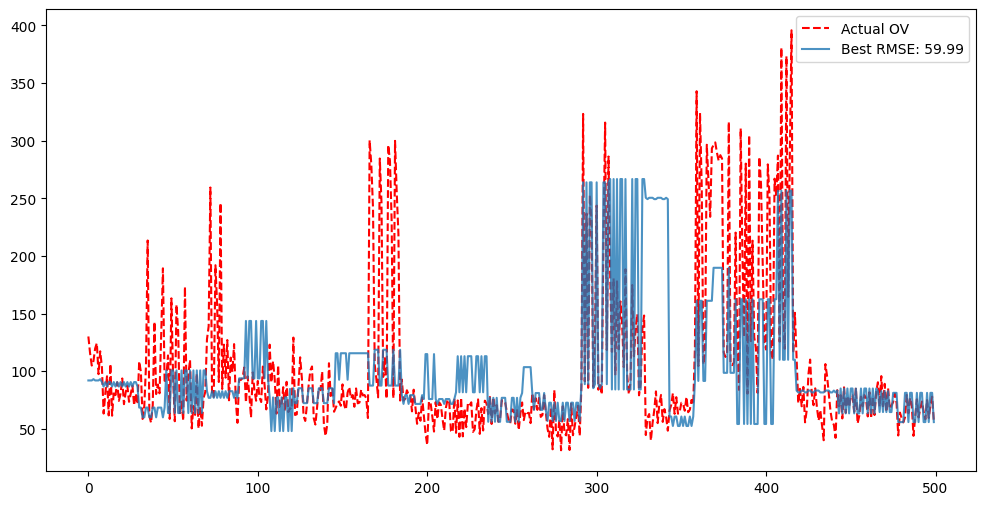

In [20]:
model = "Best"

plt.figure(figsize=(12, 6))
Y_t = raw["OV"][-500:].reset_index(drop=True)
plt.plot(Y_t, label='Actual OV', color='red', linestyle='--')
rmse = np.sqrt(mean_squared_error(Y_t, pred_list))
plt.plot(pred_list, label=f'{model} RMSE: {rmse:.2f}', alpha=0.8)
plt.legend()
plt.show()